In [1]:
from twitter_scraper_selenium import scrape_profile
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk .tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

import string
import re
import textblob
from textblob import TextBlob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import load_model

import warnings
%matplotlib inline

In [2]:
# Collecting Data
# scrape_profile(twitter_username="Babe1239407051",
#                output_format="csv",
#                browser="firefox",
#                tweets_count=1500,
#                filename="tweets",
#                directory="D:/Jupyter_Files/data",
#                headless = False)

In [3]:
df = pd.read_csv('D:/Jupyter_Files/data/tweets.csv')
df.head()

,Unnamed: 0,tweet_id,username,name,replies,retweets,likes,posted_time,content
0,0,1676632029763612673,ManishPandeyLKW,MANISH PANDEY,132,378,722,2023-07-05 16:40:00+00:00,ये कौन सा इंसाफ है भाई ???
1,1,1676775355162705921,thakurbjpdelhi,Sandeep Thakur,914,4332,5248,2023-07-06 02:09:32+00:00,दिल्ली के अमान खान के इंस्टाग्राम अकाउंट पर 16...
2,2,1676748131034357761,shellenberger,Michael Shellenberger,557,4756,20798,2023-07-06 00:21:21+00:00,Experts said yesterday's anti-censorship court...
3,3,1676754209176272897,elonmusk,Elon Musk,1371,3083,27215,2023-07-06 00:45:30+00:00,I wonder what goes on at the “regular Wednesda...
4,4,1676588159709204483,INDVivekPandey_,Vivek Pandey,1508,1217,3115,2023-07-05 13:45:41+00:00,प्रवेश शुक्ला द्वारा किया गया अपराध अक्षम्य है...


In [4]:
df.shape

(1311, 9)

In [5]:
df['posted_time'] = pd.to_datetime(df['posted_time'])
print(df['posted_time'])

0      2023-07-05 16:40:00+00:00
1      2023-07-06 02:09:32+00:00
2      2023-07-06 00:21:21+00:00
3      2023-07-06 00:45:30+00:00
4      2023-07-05 13:45:41+00:00
                  ...           
1306   2023-07-07 05:41:47+00:00
1307   2023-07-07 05:43:12+00:00
1308   2023-07-07 11:27:00+00:00
1309   2023-07-06 15:44:30+00:00
1310   2023-07-07 03:45:57+00:00
Name: posted_time, Length: 1311, dtype: datetime64[ns, UTC]


In [6]:
df.head()

,Unnamed: 0,tweet_id,username,name,replies,retweets,likes,posted_time,content
0,0,1676632029763612673,ManishPandeyLKW,MANISH PANDEY,132,378,722,2023-07-05 16:40:00+00:00,ये कौन सा इंसाफ है भाई ???
1,1,1676775355162705921,thakurbjpdelhi,Sandeep Thakur,914,4332,5248,2023-07-06 02:09:32+00:00,दिल्ली के अमान खान के इंस्टाग्राम अकाउंट पर 16...
2,2,1676748131034357761,shellenberger,Michael Shellenberger,557,4756,20798,2023-07-06 00:21:21+00:00,Experts said yesterday's anti-censorship court...
3,3,1676754209176272897,elonmusk,Elon Musk,1371,3083,27215,2023-07-06 00:45:30+00:00,I wonder what goes on at the “regular Wednesda...
4,4,1676588159709204483,INDVivekPandey_,Vivek Pandey,1508,1217,3115,2023-07-05 13:45:41+00:00,प्रवेश शुक्ला द्वारा किया गया अपराध अक्षम्य है...


In [7]:
df.isnull().sum()

Unnamed: 0     0
tweet_id       0
username       0
name           0
replies        0
retweets       0
likes          0
posted_time    0
content        0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.shape

(1311, 9)

In [10]:
eng_stop_words = list(stopwords.words('english'))

In [11]:
emoji = list(UNICODE_EMOJI.keys())

In [12]:
def ProcessedTweets(text):
    # changing tweet text to small letters
    text = text.lower()
    # removing @ and links
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text).split())
    # removing repeating characters
    text = re.sub(r'\@w+|\#\w+|\d+','',text)
    # removing punctuation and numbers
    punt = str.maketrans('','',string.punctuation+string.digits)
    text = text.translate(punt)
    # tokenizing words and removing stop words from tweet texts
    tokens = word_tokenize(text)
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [13]:
df['Processed_tweets'] = df['content'].apply(ProcessedTweets)

In [14]:
df.head()

,Unnamed: 0,tweet_id,username,name,replies,retweets,likes,posted_time,content,Processed_tweets
0,0,1676632029763612673,ManishPandeyLKW,MANISH PANDEY,132,378,722,2023-07-05 16:40:00+00:00,ये कौन सा इंसाफ है भाई ???,
1,1,1676775355162705921,thakurbjpdelhi,Sandeep Thakur,914,4332,5248,2023-07-06 02:09:32+00:00,दिल्ली के अमान खान के इंस्टाग्राम अकाउंट पर 16...,show
2,2,1676748131034357761,shellenberger,Michael Shellenberger,557,4756,20798,2023-07-06 00:21:21+00:00,Experts said yesterday's anti-censorship court...,expert said yesterday anti censorship court ru...
3,3,1676754209176272897,elonmusk,Elon Musk,1371,3083,27215,2023-07-06 00:45:30+00:00,I wonder what goes on at the “regular Wednesda...,wonder go regular wednesday meeting
4,4,1676588159709204483,INDVivekPandey_,Vivek Pandey,1508,1217,3115,2023-07-05 13:45:41+00:00,प्रवेश शुक्ला द्वारा किया गया अपराध अक्षम्य है...,show


In [15]:
# Function for polarity score
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Function to get sentiment type
#setting the conditions
def sentimenttextblob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [16]:
# using the functions to get the polarity and sentiment
df['Polarity'] = df['Processed_tweets'].apply(polarity)
df['Sentiment'] = df['Polarity'].apply(sentimenttextblob)
sent = df['Sentiment'].value_counts()
sent

Neutral     819
Positive    386
Negative    106
Name: Sentiment, dtype: int64

In [17]:
df.head(10)

,Unnamed: 0,tweet_id,username,name,replies,retweets,likes,posted_time,content,Processed_tweets,Polarity,Sentiment
0,0,1676632029763612673,ManishPandeyLKW,MANISH PANDEY,132,378,722,2023-07-05 16:40:00+00:00,ये कौन सा इंसाफ है भाई ???,,0.000000,Neutral
1,1,1676775355162705921,thakurbjpdelhi,Sandeep Thakur,914,4332,5248,2023-07-06 02:09:32+00:00,दिल्ली के अमान खान के इंस्टाग्राम अकाउंट पर 16...,show,0.000000,Neutral
2,2,1676748131034357761,shellenberger,Michael Shellenberger,557,4756,20798,2023-07-06 00:21:21+00:00,Experts said yesterday's anti-censorship court...,expert said yesterday anti censorship court ru...,-0.233333,Negative
3,3,1676754209176272897,elonmusk,Elon Musk,1371,3083,27215,2023-07-06 00:45:30+00:00,I wonder what goes on at the “regular Wednesda...,wonder go regular wednesday meeting,0.000000,Neutral
4,4,1676588159709204483,INDVivekPandey_,Vivek Pandey,1508,1217,3115,2023-07-05 13:45:41+00:00,प्रवेश शुक्ला द्वारा किया गया अपराध अक्षम्य है...,show,0.000000,Neutral
5,5,1676809355641909251,Ankitydv92,Ankit Yadav Bojha,265,3077,19056,2023-07-06 04:24:38+00:00,बहाने बनाने वाले के पास काम नहीं है\nकाम करने ...,,0.000000,Neutral
6,6,1676955956813631489,narendramodi,Narendra Modi,360,2225,6955,2023-07-06 14:07:11+00:00,कल रायपुर में \n@BJP4CGState\n की रैली में जनत...,,0.000000,Neutral
7,7,1676911170077487104,imVkohli,Virat Kohli,359,2319,35404,2023-07-06 11:09:13+00:00,Welcome to the mothership.\n\n#StayMad #StayWr...,welcome mothership staymad staywrogn ad,0.800000,Positive
8,8,1677138761455636482,CricCrazyJohns,Johns.,77,1178,9902,2023-07-07 02:13:35+00:00,2007 - T20 WC\n2010 - IPL\n2010 - Test Mace\n2...,wc ipl test mace asia cup cl odi wc test mace ...,1.000000,Positive
9,9,1677215549346963456,aajtak,AajTak,4,14,109,2023-07-07 07:18:42+00:00,कोल्हापुर - ऑटो रिक्शा में फंसी महिला की साड़ी...,cctv kolhapur maharashtra autodriver,0.000000,Neutral


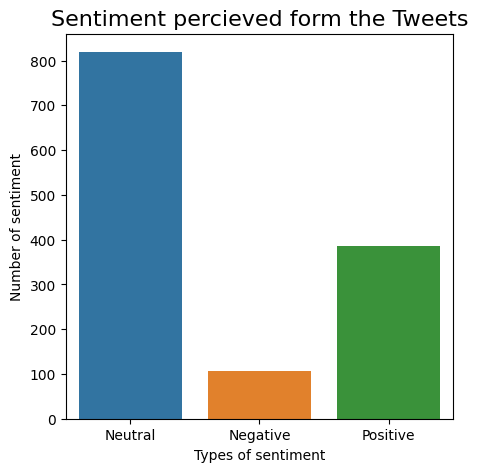

In [18]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Sentiment', data = df)
plt.title('Sentiment percieved form the Tweets', fontsize=16)
plt.xlabel('Types of sentiment')
plt.ylabel('Number of sentiment');

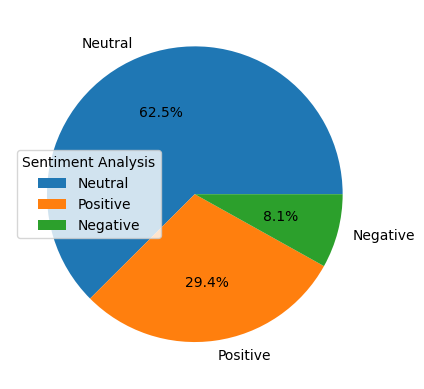

In [19]:
# Plotting Pie chart for Sentiments
plt.pie(sent, labels = ['Neutral','Positive', 'Negative'], autopct='%1.1f%%')
plt.legend(title = "Sentiment Analysis")
plt.show() 

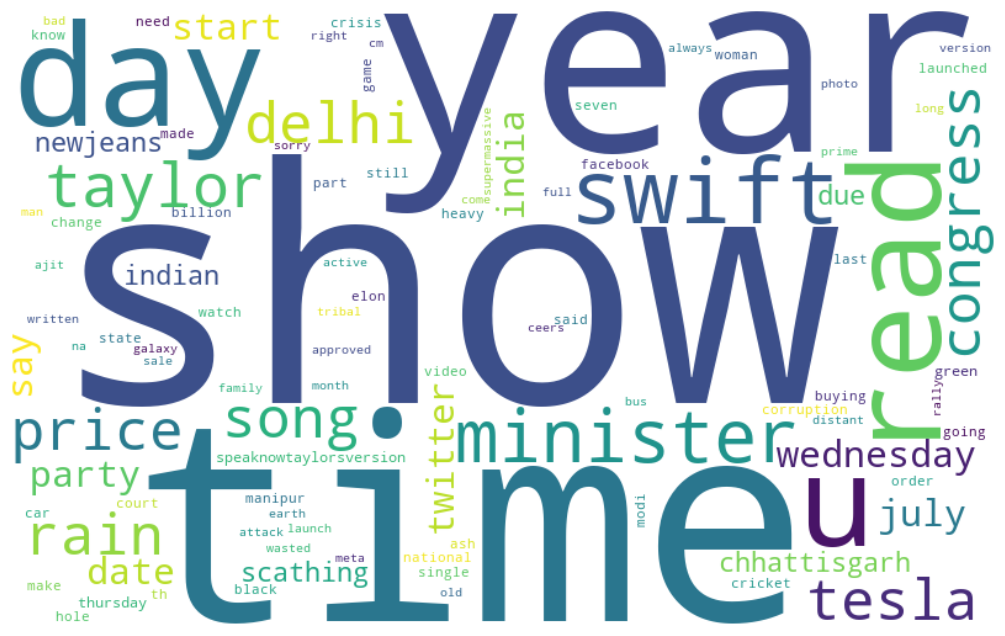

In [20]:
# Words with negative sentiments
neg_words = " ".join([sentence for sentence in df['Processed_tweets'][df['Polarity']<0]])

wordcloud = WordCloud(width=800, height=500, collocations=False, max_words=100, background_color = 'white').generate(neg_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

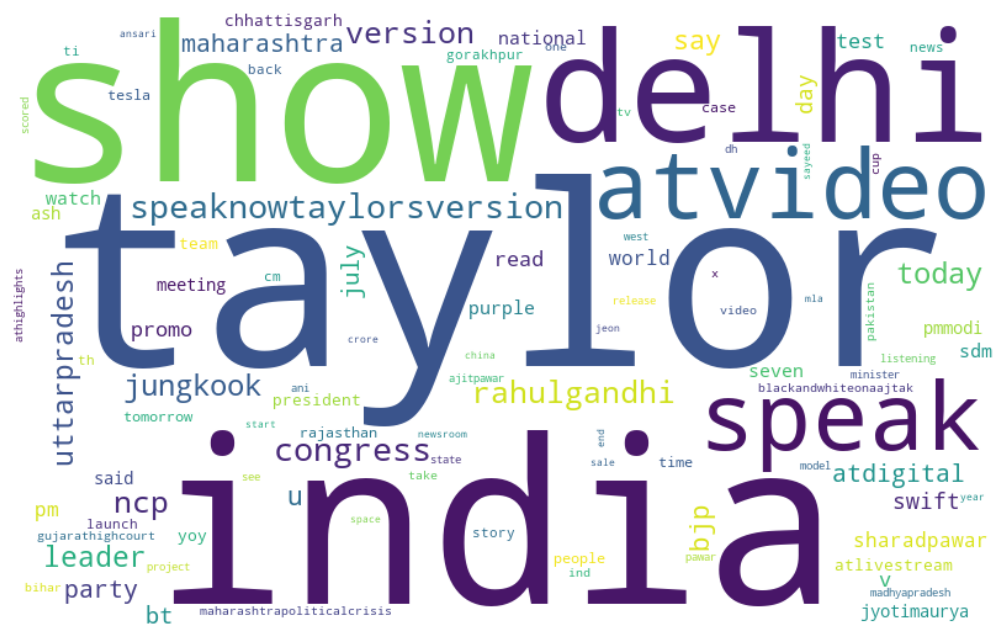

In [21]:
# Words with neutral sentiments
neut_words = " ".join([sentence for sentence in df['Processed_tweets'][df['Polarity']==0]])

wordcloud = WordCloud(width=800, height=500, collocations=False, max_words=100, background_color = 'white').generate(neut_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

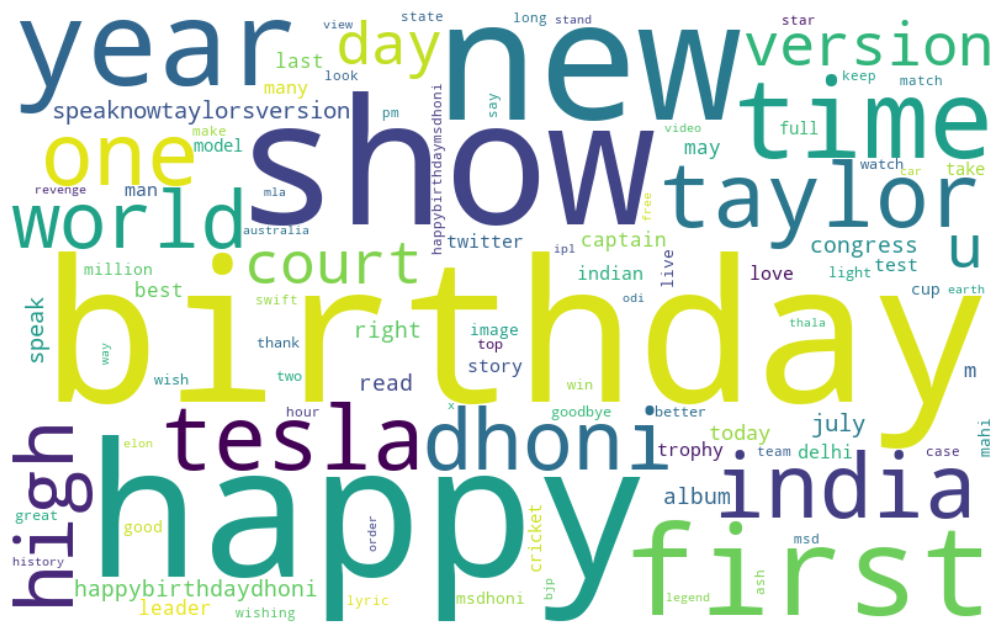

In [22]:
# Words with Positive Sentiments
pos_words = " ".join([sentence for sentence in df['Processed_tweets'][df['Polarity']>0]])

wordcloud = WordCloud(width=800, height=500, collocations=False, max_words=100, background_color = 'white').generate(pos_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

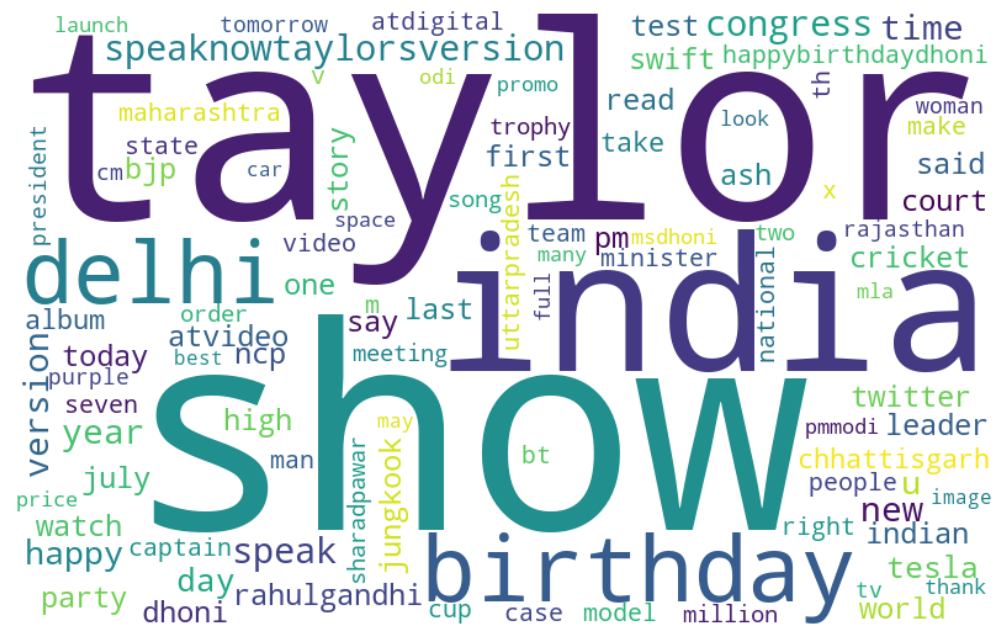

In [23]:
# Frequently occured words
all_words = " ".join([sentence for sentence in df['Processed_tweets']])

wordcloud = WordCloud(width=800, height=500, collocations=False, max_words=100, background_color = 'white').generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
X = df.content
y = df.Sentiment

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

In [26]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=50, ngram_range=(1, 2))

In [27]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

### Model1: Bernoulli Naive Bayes Classifier

In [28]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)

BNB accuracy: 74.14%




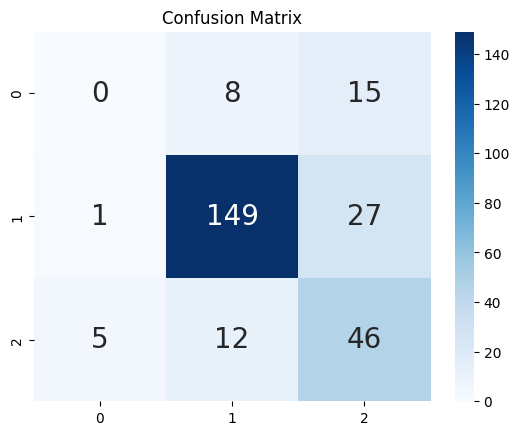



              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
     Neutral       0.88      0.84      0.86       177
    Positive       0.52      0.73      0.61        63

    accuracy                           0.74       263
   macro avg       0.47      0.52      0.49       263
weighted avg       0.72      0.74      0.73       263



In [29]:
BNB_acc = accuracy_score(y_pred1, y_test)
print("BNB accuracy: {:.2f}%".format(BNB_acc*100))
print("\n")
cm = confusion_matrix(y_test, y_pred1)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={'size':20}, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
plt.show()
print("\n")
print(classification_report(y_test, y_pred1))

### Model 2: SVM (Support Vector Machine)

In [30]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred2 = SVCmodel.predict(X_test)

SVC accuracy: 73.38%




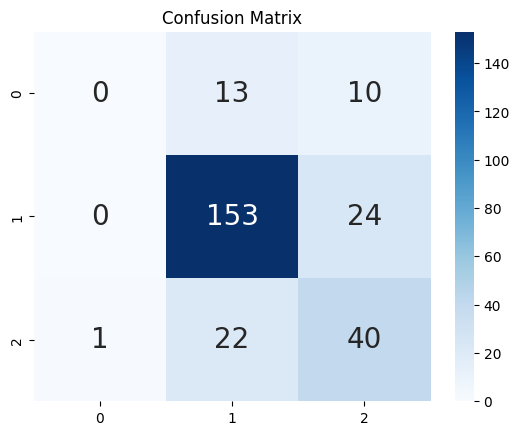



              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
     Neutral       0.81      0.86      0.84       177
    Positive       0.54      0.63      0.58        63

    accuracy                           0.73       263
   macro avg       0.45      0.50      0.47       263
weighted avg       0.68      0.73      0.70       263



In [31]:
SVC_acc = accuracy_score(y_pred2, y_test)
print("SVC accuracy: {:.2f}%".format(SVC_acc*100))
print("\n")
cm = confusion_matrix(y_test, y_pred2)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={'size':20}, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
plt.show()
print("\n")
print(classification_report(y_test, y_pred2))

### Model 3: Logistic Regression

In [32]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred3 = LRmodel.predict(X_test)

LR accuracy: 73.00%




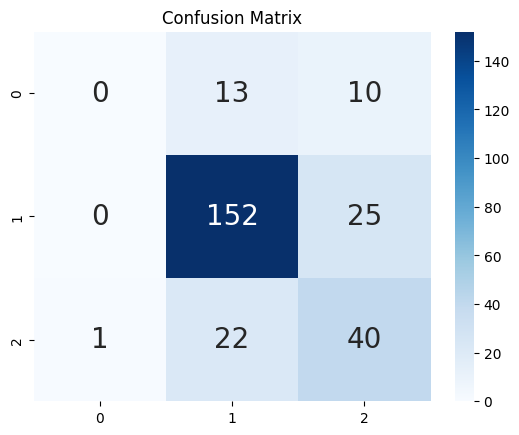



              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
     Neutral       0.81      0.86      0.84       177
    Positive       0.53      0.63      0.58        63

    accuracy                           0.73       263
   macro avg       0.45      0.50      0.47       263
weighted avg       0.67      0.73      0.70       263



In [33]:
LR_acc = accuracy_score(y_pred3, y_test)
print("LR accuracy: {:.2f}%".format(LR_acc*100))
print("\n")
cm = confusion_matrix(y_test, y_pred3)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={'size':20}, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
plt.show()
print("\n")
print(classification_report(y_test, y_pred3))

### LSTM Model

In [34]:
df = df[['content','Sentiment']]
df = df[df.Sentiment != 'Neutral']

df = df[df.Sentiment != "Neutral"]
df['content'] = df['content'].apply(lambda x: x.lower())
df['content'] = df['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

In [35]:
df.head(20)

,content,Sentiment
2,experts said yesterdays anticensorship court r...,Negative
7,welcome to the mothership\n\nstaymad staywrogn...,Positive
8,2007 t20 wc\n2010 ipl\n2010 test mace\n2010...,Positive
14,happy birthday to lt col mahendra singh dhoni ...,Positive
17,birthday greetings to the padma bhushan \nmsdh...,Positive
20,an inspiration to so many people across the co...,Positive
24,watch gujarat high court verdict on defamatio...,Negative
29,wishing the legend and the greatest ever to pl...,Positive
31,posting my full conversation with \nrobertkenn...,Positive
34,clever this certainly beats all the effort i r...,Positive


In [36]:
X = df.content
y = df.Sentiment

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print("Training Set X Items: " + str(len(X_train)))
print("Training Set y Items: " + str(len(y_train)))

Training Set X Items: 393
Training Set y Items: 393


In [39]:
print("Test Set X Items: " + str(len(X_test)))
print("Test Set y Items: " + str(len(y_test)))

Test Set X Items: 99
Test Set y Items: 99


In [40]:
review_labels_train = y_train.factorize()

In [41]:
review_labels_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [42]:
review_labels_train[1]

Index(['Positive', 'Negative'], dtype='object')

In [43]:
vocab = X_train.values
vocab

array(['long live all the beautiful speaknowtaylorsversion merch we made  available while supplies last at httpstoretaylorswiftcom',
       'the  wonders of our legendary number seven  \n\na leader like none other happy birthday msd ',
       'donald trump raises over 35 million for quarter despite legal woes \n\nformer president donald trump raked in more than 35 million in the second quarter as his army of smalldollar donors rallied to his side even as his legal woes mounted',
       'speak now is for the girls who never had a single romantic interaction in the year 2010 but still cried on the floor of their bedrooms listening to last kiss on their itouch',
       'happy born day mahi bhai  \nmahi7781\n \n\n\n\n\nhappybirthdaydhoni mahi mahibhai csk chennaisuperkings 7 thala karnsharma',
       'ms dhoni is the oldest player to win the player of the series award in australia in odis',
       'video falaknuma express train catches fire near hyderabad close shave for passengers\n\nhttp

In [44]:
tokenizer = Tokenizer(num_words=8000,oov_token='OOV')
tokenizer.fit_on_texts(vocab)

vocab_size = len(tokenizer.word_index) + 1

print(tokenizer)
print(vocab_size)

3414


In [45]:
len(tokenizer.word_index)

3413

In [46]:
import pickle
with open('sem.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
tweet = X_train.values

tweet_seqs = tokenizer.texts_to_sequences(tweet)

padded_sequence_train = pad_sequences(tweet_seqs, maxlen=200)
print(padded_sequence_train)

[[   0    0    0 ...   75   23 1198]
 [   0    0    0 ...   19   16  174]
 [   0    0    0 ...  324  674 1206]
 ...
 [   0    0    0 ... 3396   25   11]
 [   0    0    0 ...  536    4 1191]
 [   0    0    0 ...   21    9  415]]


In [48]:
print(padded_sequence_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  156  135   31    2  320   49 1196   62  136  321  204
 1197 

In [49]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           109248    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 125,899
Trainable params: 125,899
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
model.save("sentiment_analysis.h5")
print("Model Saved")

Model Saved


In [51]:
# Training the model
trained = model.fit(padded_sequence_train,review_labels_train[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
10/10 [==============================] - 27s 2s/step - loss: 0.6790 - accuracy: 0.7548 - val_loss: 0.6515 - val_accuracy: 0.7848
Epoch 2/5
10/10 [==============================] - 19s 2s/step - loss: 0.5563 - accuracy: 0.7866 - val_loss: 0.5789 - val_accuracy: 0.7848
Epoch 3/5
10/10 [==============================] - 22s 2s/step - loss: 0.5353 - accuracy: 0.7866 - val_loss: 0.5247 - val_accuracy: 0.7848
Epoch 4/5
10/10 [==============================] - 21s 2s/step - loss: 0.5051 - accuracy: 0.7866 - val_loss: 0.5261 - val_accuracy: 0.7848
Epoch 5/5
10/10 [==============================] - 19s 2s/step - loss: 0.4913 - accuracy: 0.7866 - val_loss: 0.5258 - val_accuracy: 0.7848


In [52]:
encoded_docs = tokenizer.texts_to_sequences(X_test)
padded_sequence_test = pad_sequences(encoded_docs, maxlen=200)
print(padded_sequence_test)

[[   0    0    0 ...  140   76   22]
 [   0    0    0 ...    4    1    1]
 [   0    0    0 ... 1075 1177 1021]
 ...
 [   0    0    0 ...  538    4  370]
 [   0    0    0 ...   82   25   11]
 [   0    0    0 ...  307  963 2295]]


In [53]:
sentiment_label_test = y_test.factorize()
sentiment_label_test[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [69]:
score = model.evaluate(padded_sequence_test,sentiment_label_test[0],verbose=0)

In [70]:
print("LSTM Score: {}".format(score))

LSTM Score: [0.5262753367424011, 0.7777777910232544]


In [72]:
from keras.models import load_model
model = load_model('sentiment_analysis.h5')
print("Model Loaded")
model.summary()

Model Loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           109248    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 125,899
Trainable params: 125,899
Non-trainable params: 0
_________________________________________________________________


In [73]:
score = model.evaluate(padded_sequence_test,sentiment_label_test[0],verbose=0)

In [74]:
print("LSTM Accuracy: {}".format(score)) 

LSTM Accuracy: [0.6937510967254639, 0.4040403962135315]


In [75]:
import pickle
with open('sem.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [76]:
len(tokenizer.word_index)

3413

In [77]:
# Test Review Sentence

test_word ="""
Experts said yesterday's anti-censorship court ruling was too badly written to be implemented, but it's already working. The State Department today canceled its regular Wednesday meeting with Facebook, and all future meetings, "pending further guidance.â€
"""

# To
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)

tw

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
# prediction = int(model.predict(tw).round().item())
# outcome = (review_labels_train[1][prediction]).capitalize()
# sen = 'Negative' if outcome == 0 else 'Positive'
# print(sen)
# # print("Actual Review: " + test_word)
# # print("\nSentiment Analysis Outcome ==> The review shows " + (review_labels_train[1][prediction]).capitalize() + " sentiment.")
# # print("\n======================================================================================")

# # print("\nAccuracy Criteria \n\nProbability Closer to 0 == Negative Sentiment\nProbability Closer to 1 == Positive Sentiment")

# prob = model.predict(tw)[0][0]

# print("\n ==> Probability is " + str(prob)+ " (" + outcome + ")")

In [79]:
probability = model.predict(tw)[0][0]
prediction = int(model.predict(tw).round().item())
outcome = 'Negative' if prediction == 0 else 'Positive'
print(probability)
print(outcome)

0.5000262
Positive
